In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'labels.csv', 'sample_submission.csv', 'test']


In [2]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
multiGPU = False
useGPU = True

In [3]:
train_path = "../input/train"
test_path = "../input/test"
label_path = "../input/labels.csv"
sample_path = "../input/sample_submission.csv"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [4]:
class DogsDataset(Dataset):
    """Dog breed identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) + ".jpg"
        image = Image.open(img_name)
        label = self.labels_frame.target[idx]

        if self.transform:
            image = self.transform(image)
        return [image, label]

cairn
Shape of the image is:  (500, 375)


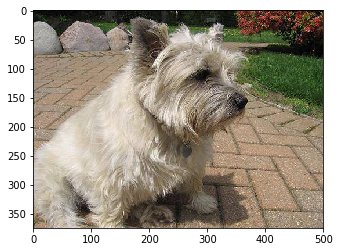

In [11]:
dframe = pd.read_csv(label_path)
labelnames = pd.read_csv(sample_path).keys()[1:]
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
dframe['target'] =  [breed_to_code[x] for x in dframe.breed]

cut = int(len(dframe)*0.8)
train, test = np.split(dframe, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = DogsDataset(train_path, train)
test_ds = DogsDataset(test_path, test)
idx = 29
plt.imshow(train_ds[idx][0])
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].size)

In [8]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

train_ds = DogsDataset(train_path, train, data_transform)
test_ds = DogsDataset(test_path, test, data_transform)
datasets = {"train": train_ds, "val": test_ds}

idx = 29
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].shape)

cairn
Shape of the image is:  torch.Size([3, 224, 224])


In [12]:
trainloader = DataLoader(train_ds, batch_size=4,
                        shuffle=True, num_workers=4)

testloader = DataLoader(test_ds, batch_size=4,
                        shuffle=True, num_workers=4)

dataloaders = {"train": trainloader, "val": testloader}